In [9]:
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from numba_func import *

# Numba can beat Numpy

**still easy to read and short enough**

***Illustrative example using a markov chain.***

![markov chain: cheese lettuce grapes, from Wiki](https://upload.wikimedia.org/wikipedia/commons/f/f2/Markov-cheese-lettuce-grapes.svg)\
Source: [Wikipedia](https://en.wikipedia.org/wiki/Markov_chain)

A (discrete-time) markov chain is a stochastic model with many real life applications. See the relevant [Wikipedia](https://en.wikipedia.org/wiki/Markov_chain) page for more information. The model is described in terms of
* a finite set of states
* transition probabilities from one state to another state

To simulate a markov chain, 
* set the intial state
* draw a uniform random number between 0 and 1
* compare to the cumulative transition probabilities to determine the next state
* repeat

## markov chain simulation function

### three versions
1. Native Python
1. Native Python with numby (via njit)
1. Numpy implementation

Notes:
* All functions have the same arguments
* In the first two functions, we use a digitize function for scalar, which is compiled via numba. (see numba_func.py)
* In this case, the numba implementation is as easy to read and as short as the numpy implementation!

In [2]:
# Nativa Python version
def markov_chain_simulation_naive(v_curr_state, v_draw, mtx_CTP0):
    """Markov chain simulation

    Args:
        v_curr_state (1-d numpy vector, integer): vector of current states
        v_draw (1-d numpy vector, float): vector of uniform random numbers between 0 and 1
        mtx_CTP0 (1-d numpy matrix, float): cumulative transition probability matrix without the last column (which consists of ones by definition)

    Returns:
        1-d numpy vector, integer: vector of next states
    """

    v_next_state = np.empty_like(v_curr_state)
    for n in range(v_next_state.size):
        curr_s = v_curr_state[n]
        v_next_state[n] = digitize_scalar_nb(v_draw[n], mtx_CTP0[curr_s])
    
    return v_next_state

# Nativa Python version (identical to above), numba'ed
@njit(fastmath=True, cache=True)
def markov_chain_simulation_nb(v_curr_state, v_draw, mtx_CTP0):
    v_next_state = np.empty_like(v_curr_state)
    for n in range(v_next_state.size):
        curr_s = v_curr_state[n]
        v_next_state[n] = digitize_scalar_nb(v_draw[n], mtx_CTP0[curr_s])
    return v_next_state

# call the above function, so that it is compiled and cached before running the benchmark runs below
markov_chain_simulation_nb(np.zeros(1, dtype=np.int64), np.zeros(1), np.array([[0.2]]))

# Numpy implementation
def markov_chain_simulation_np(v_curr_state, v_draw, mtx_CTP0):
    v_next_state = np.empty_like(v_curr_state)
    for s in range(0, mtx_CTP0.shape[0]):
        mask = v_curr_state == s
        v_next_state[mask] = np.digitize(v_draw[mask], mtx_CTP0[s])
    return v_next_state

## Transition Probability Matrix

* create a transition probability matrix using random numbers
* normalise each row to add up to one. 
* calculate the cumulative probability matrix. The last column, which consists of ones by definition, should be removed. 

In [3]:
# number of states
num_state = 5

# define transition probability matrix
mtx_TP = np.random.uniform(0.0, 1.0, (num_state, num_state))
mtx_TP /= np.sum(mtx_TP, axis=1, keepdims=True)

# cumulative transition probability matrix
mtx_CPT = np.cumsum(mtx_TP, axis=1)
mtx_CPT0 = mtx_CPT[:,:-1]

print('Transition Matrix')
print(mtx_TP)
print('Cumulative Transition Matrix')
print(mtx_CPT)

Transition Matrix
[[0.20289144 0.14380793 0.14427834 0.20209597 0.30692632]
 [0.23328553 0.09236205 0.31615264 0.15052147 0.20767831]
 [0.20913143 0.39641361 0.11154029 0.23218871 0.05072597]
 [0.17409624 0.00715258 0.06328254 0.53508457 0.22038407]
 [0.09823349 0.00886643 0.30299593 0.20437977 0.38552438]]
Cumulative Transition Matrix
[[0.20289144 0.34669937 0.4909777  0.69307368 1.        ]
 [0.23328553 0.32564758 0.64180022 0.79232169 1.        ]
 [0.20913143 0.60554504 0.71708532 0.94927403 1.        ]
 [0.17409624 0.18124882 0.24453136 0.77961593 1.        ]
 [0.09823349 0.10709991 0.41009585 0.61447562 1.        ]]


## Experiment 1
* 10 steps
* 1M scenarios

Time taken: 
naive >> numpy > numba

The numba verison is 
* over 50 time faster than the naive version
* over 3 time faster than the **numpy** version

In [14]:
num_step = 10
seed = 1234

num_draw = 1000000

# initialise
v_init_state = np.random.randint(0, num_state, num_draw)

# simulation: naive
rng = np.random.default_rng(seed)
td = 0.0
v_next_naive = v_init_state.copy()
for n in range(num_step):
    v_draw = rng.uniform(0.0, 1.0, num_draw)
    t0 = time.time()
    v_next_naive = markov_chain_simulation_naive(v_next_naive, v_draw, mtx_CPT0)
    td += time.time() - t0
print('naive: ' + str(td) + ' seconds')

# simulation: numba
rng = np.random.default_rng(seed)
td = 0.0
v_next_nb = v_init_state.copy()
for n in range(num_step):
    v_draw = rng.uniform(0.0, 1.0, num_draw)
    t0 = time.time()
    v_next_nb = markov_chain_simulation_nb(v_next_nb, v_draw, mtx_CPT0)
    td += time.time() - t0
print('numba: ' + str(td) + ' seconds')

# simulation: numpy
rng = np.random.default_rng(seed)
td = 0.0
v_next_np = v_init_state.copy()
for n in range(num_step):
    v_draw = rng.uniform(0.0, 1.0, num_draw)
    t0 = time.time()
    v_next_np = markov_chain_simulation_np(v_next_np, v_draw, mtx_CPT0)
    td += time.time() - t0
print('numpy: ' + str(td) + ' seconds')

print('result check: is naive equal to numba?', np.array_equal(v_next_naive, v_next_nb))
print('result check: is naive equal to numpy?', np.array_equal(v_next_naive, v_next_np))

naive: 6.776994705200195 seconds
numba: 0.12207150459289551 seconds
numpy: 0.4272336959838867 seconds
result check: is naive equal to numba? True
result check: is naive equal to numpy? True


## Experiment 2
* 10 steps
* 10M scenarios (10 times of experiment 1)
* only numpy and numba

Again, the numba verison is over 3 time faster than the **numpy** version

In [15]:
num_draw = 10000000
v_init_state = np.random.randint(0, num_state, num_draw)

# simulation: numba
rng = np.random.default_rng(seed)
td = 0.0
v_next_nb = v_init_state.copy()
for n in range(num_step):
    v_draw = rng.uniform(0.0, 1.0, num_draw)
    t0 = time.time()
    v_next_nb = markov_chain_simulation_nb(v_next_nb, v_draw, mtx_CPT0)
    td += time.time() - t0
print('numba: ' + str(td) + ' seconds')

# simulation: numpy
rng = np.random.default_rng(seed)
td = 0.0
v_next_np = v_init_state.copy()
for n in range(num_step):
    v_draw = rng.uniform(0.0, 1.0, num_draw)
    t0 = time.time()
    v_next_np = markov_chain_simulation_np(v_next_np, v_draw, mtx_CPT0)
    td += time.time() - t0
print('numpy: ' + str(td) + ' seconds')

print('result check: is numpy equal to numba?', np.array_equal(v_next_np, v_next_nb))

numba: 1.3930959701538086 seconds
numpy: 4.904888153076172 seconds
result check: is numpy equal to numba? True


# Plot some paths

In [26]:
num_draw = 7
v_init_state = np.full(num_draw, 2)

# simulation: numba
rng = np.random.default_rng(seed)
l_state = []
v_next_nb = v_init_state.copy()
l_state.append(v_next_nb)
for n in range(num_step):
    v_draw = rng.uniform(0.0, 1.0, num_draw)
    v_next_nb = markov_chain_simulation_nb(v_next_nb, v_draw, mtx_CPT0)
    l_state.append(v_next_nb)

mtx_state = np.array(l_state)


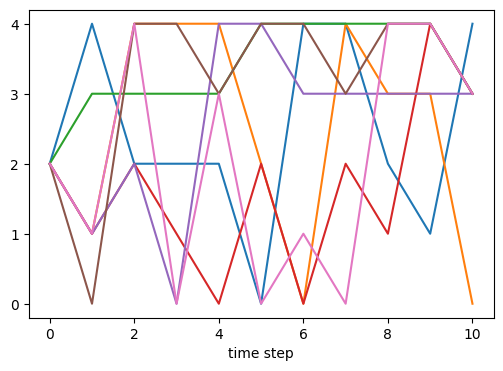

In [27]:
plt.figure(figsize=(6,4))
plt.plot(range(num_step+1), mtx_state)
plt.xlabel('time step')
plt.yticks(range(num_state), [str(s) for s in range(num_state)])
plt.show()